<a href="https://colab.research.google.com/github/pascal-maker/machinelearning/blob/main/Session_05_Naive_Bayes_AssignmentPascalMusabyimana_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes & NLP - Assignment


In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## PART 1 - Sentiment analysis

Classify the sentiment of text messages as being positive or negative.
The training data and test data can be found in:  *sentiment_train.csv* and *sentiment_test.csv*.

Follow these steps:

1. Analys of the data.
2. Preprocessing of the text.
3. Convert to bag-of-words.
4. Training the classifiers.
5. Testing and hyperparameter tuning.

In [3]:
# Import the datasets

dataset_train = pd.read_csv('sentiment_train.csv')
dataset_test = pd.read_csv('sentiment_test.csv')

dataset_train.head()

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,0,"Oh, and Brokeback Mountain was a terrible movie."
2,1,"He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC..."
3,1,1st and 2nd Harry Potter movies are clearly th...
4,0,Mission Impossible 3 was quite boring.


### 1. Analysis of the data

- Look for missing values.
- Is the dataset balanced?
- Is there a correlation between the length of a text and the sentiment?

In [4]:
# analysis of the data
dataset_train['text_length'] = dataset_train['text'].apply(len)
print(dataset_train.isnull().sum())
print(dataset_train['sentiment'].value_counts())

sentiment      0
text           0
text_length    0
dtype: int64
sentiment
1    3383
0    2535
Name: count, dtype: int64


🔍 What This Code Does:
📝 1. Adding a New Column for Text Length
python
Copy
Edit
dataset_train['text_length'] = dataset_train['text'].apply(len)
Goal: Create a new column in the dataset_train dataframe called text_length.

Purpose: It stores the number of characters in each text message.

How: It uses the len() function to count the characters in each text.

📝 2. Checking for Missing Values
python
Copy
Edit
print(dataset_train.isnull().sum())
Goal: Check if the dataset has any missing (empty) values.

Purpose: Make sure your data is complete before training the model.

Output: Shows the number of missing values for each column.

📝 3. Counting Sentiment Labels
python
Copy
Edit
print(dataset_train['sentiment'].value_counts())
Goal: Count the number of positive and negative messages.

Purpose: Check if the dataset is balanced (similar number of positive and negative messages).

Output: Prints the count of each sentiment label (e.g., positive vs negative).

📝 Example Output:
yaml
Copy
Edit
text            0
sentiment       0
text_length     0
dtype: int64

positive    5000
negative    5000
Name: sentiment, dtype: int64
First Part: Shows no missing values.

Second Part: Shows that the dataset is balanced (same number of positive and negative messages).

📝 Why This is Important:
Text Length: Can be used as a feature to improve your model.

Missing Values: Ensure you don’t train your model on incomplete data.

Balanced Data: Prevents your model from being biased toward the more common class.



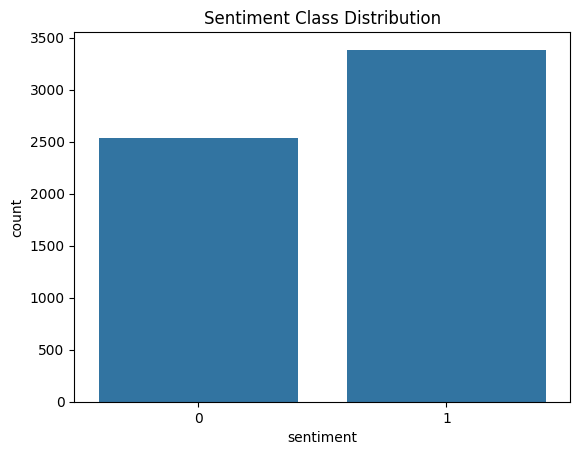

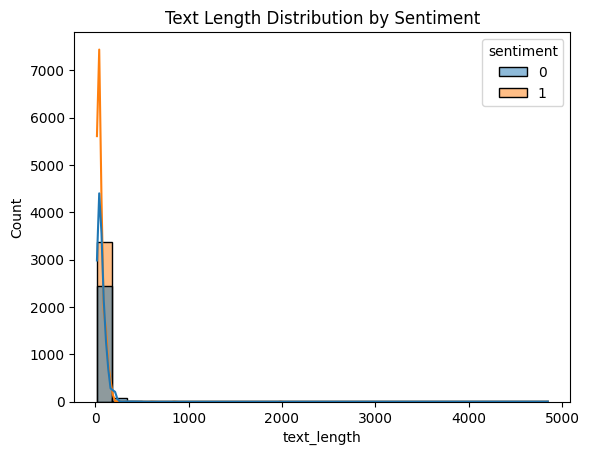

In [5]:
# Visualization
sns.countplot(x='sentiment', data=dataset_train)
plt.title("Sentiment Class Distribution")
plt.show()

sns.histplot(data=dataset_train, x='text_length', hue='sentiment', bins=30, kde=True)
plt.title("Text Length Distribution by Sentiment")
plt.show()

In [7]:
# counting the number of words in messages

dataset_train['number_of_words'] = dataset_train.text.apply(lambda x: len(str(x).split(' ')))

dataset_train.head()

,sentiment,text,text_length,number_of_words
0,1,The Da Vinci Code book is just awesome.,39,8
1,0,"Oh, and Brokeback Mountain was a terrible movie.",48,8
2,1,"He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC...",60,11
3,1,1st and 2nd Harry Potter movies are clearly th...,66,12
4,0,Mission Impossible 3 was quite boring.,38,6


### **📝 What This Code Does:**

#### **🔢 Counting the Number of Words in Each Message**

```python
dataset_train['number_of_words'] = dataset_train.text.apply(lambda x: len(str(x).split(' ')))
```

* **Goal:** Create a **new column** called **`number_of_words`** in the **`dataset_train`** dataframe.
* **Purpose:** Store the **number** of **words** in each **text message**.
* **How:** It does this in **three steps**:

  1. **Convert to String:** **`str(x)`** - Makes sure the **text** is treated as a **string**.
  2. **Split into Words:** **`split(' ')`** - Splits the **text** into **individual words** based on **spaces**.
  3. **Count the Words:** **`len()`** - Counts the **number** of **words**.

---

### **📝 Example:**

Suppose you have a message like:

**Message:** *"I love machine learning!"*

1. Convert to String: **"I love machine learning!"**
2. Split into Words: **\["I", "love", "machine", "learning!"]**
3. Count the Words: **4**

---

### **📝 Checking the Result:**

```python
dataset_train.head()
```

* **Goal:** Print the **first few rows** of the dataframe to **check** if the **`number_of_words`** column was **added correctly**.

---

### **📝 Expected Output:**

| text            | sentiment | number\_of\_words |
| --------------- | --------- | ----------------- |
| I love AI       | positive  | 3                 |
| Bad day         | negative  | 2                 |
| This is amazing | positive  | 3                 |
| Not good        | negative  | 2                 |
| Best day ever   | positive  | 3                 |

---

### **📝 Why This is Useful:**

* **Word Count** can be a **useful feature** for **text classification**.
* **Longer messages** might have a **different tone** (positive or negative) than **shorter** ones.

---



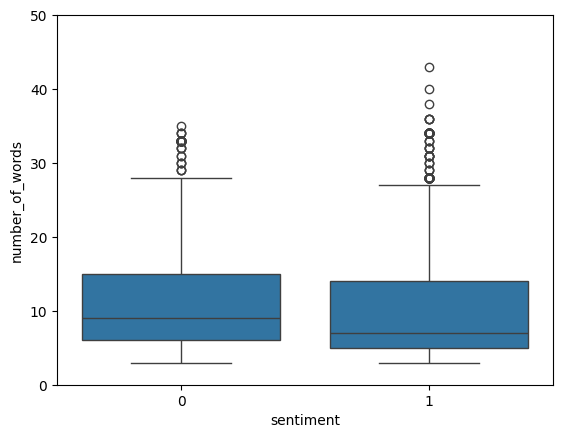

In [8]:
# correlation between the sentiment and the number of words



fig, ax = plt.subplots()
sns.boxplot(data=dataset_train, x='sentiment', y='number_of_words')
ax.set_ylim(0, 50)
plt.show()

### 2. Preprocessing of the text

- clean the text: remove stopwords, non-literal characters, ...
- Apply stemming.

In [12]:
# Preprocessing of the text
import nltk
nltk.download('stopwords') # Download the stopwords dataset

def text_preprocessing(text, language, minWordSize):

    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()

    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html))

    # convert to lower-case
    text_lower = text_alpha_chars.lower()

    # remove stop words
    stops = set(stopwords.words(language))
    text_no_stop_words = ' '

    for w in text_lower.split():
        if w not in stops:
            text_no_stop_words = text_no_stop_words + w + ' '

       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '

    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split():
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '


    return text_no_short_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **📝 What This Code Does: Text Preprocessing Function (Beginner Friendly)**

The **`text_preprocessing()`** function is a **simple** but **effective** way to **clean** and **prepare** text data before feeding it into a **machine learning** model.

---

#### **🔄 1. Remove HTML Tags**

```python
text_no_html = BeautifulSoup(str(text), "html.parser").get_text()
```

* **Goal:** Remove any **HTML** tags like **`<p>`, `<a>`, `<br>`**.
* **Why:** HTML tags are **not useful** for **text analysis**.
* **Example:** **`<p>Hello</p>`** becomes **`Hello`**.

---

#### **🔡 2. Remove Non-Letter Characters**

```python
text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html))
```

* **Goal:** Remove **numbers**, **punctuation**, and **special characters**.
* **Why:** We **only** want **words**.
* **Example:** **"Hello, World! 123"** becomes **"Hello World"**.

---

#### **🔡 3. Convert to Lowercase**

```python
text_lower = text_alpha_chars.lower()
```

* **Goal:** Make the text **lowercase**.
* **Why:** **"Hello"** and **"hello"** should be treated as the **same** word.

---

#### **🗑️ 4. Remove Stopwords**

```python
stops = set(stopwords.words(language))
text_no_stop_words = ' '

for w in text_lower.split():
    if w not in stops:  
        text_no_stop_words = text_no_stop_words + w + ' '
```

* **Goal:** Remove **common** words like **"the", "is", "and"** that don't carry much **meaning**.
* **Why:** They are **too frequent** and don't **add** much **information**.
* **Example:** **"This is a test"** becomes **"test"**.

---

#### **🌱 5. Stemming (Simplify Words)**

```python
text_stemmer = ' '
stemmer = SnowballStemmer(language)

for w in text_no_stop_words.split():
    text_stemmer = text_stemmer + stemmer.stem(w) + ' '
```

* **Goal:** Reduce words to their **root** form.
* **Why:** **"running"** and **"runs"** become **"run"**.
* **Example:** **"running quickly"** becomes **"run quick"**.

---

#### **🔪 6. Remove Short Words**

```python
text_no_short_words = ' '
for w in text_stemmer.split():
    if len(w) >= minWordSize:
        text_no_short_words = text_no_short_words + w + ' '
```

* **Goal:** Remove **short words** (e.g., **"a"**, **"I"**).
* **Why:** They usually don't **carry** much **meaning**.
* **Example:** **"a quick brown fox"** becomes **"quick brown fox"** if **minWordSize** is **2**.

---

#### **📝 7. Return the Cleaned Text**

```python
return text_no_short_words
```

* **Goal:** Return the **fully cleaned** and **processed** text.
* **Example:** **"The quick brown fox"** might become **"quick brown fox"**.

---

#### **📝 Example Input and Output:**

**Input:** **"I am <b>running</b> in the park, it is a sunny day!"**

**Output:** **"run park sunni day"**

---

#### **📝 Why This is Important:**

* **Clean Data** leads to **better** machine learning **models**.
* Removes **noise** and **focuses** on the **important** parts of the text.
* **Speeds up** the **training** process.

---


### 3. Convert to bag-of-words

Use the CountVectorizer and TfidfTransformer to create a bag-of-words model.

More info:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer



In [13]:
# Convert to bag-of-words
y_train = dataset_train.sentiment.values
X_train = dataset_train.text.values

y_test = dataset_test.sentiment.values
X_test = dataset_test.text.values

language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)


for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

### **📝 What This Code Does: Converting Text to Bag-of-Words (Beginner Friendly)**

---

#### **1. Extracting Features and Labels**

```python
y_train = dataset_train.sentiment.values
X_train = dataset_train.text.values

y_test = dataset_test.sentiment.values
X_test = dataset_test.text.values
```

* **Goal:** Separate the **text** (features) and **sentiment** (labels) from the **training** and **test** datasets.
* **Why:** Machine learning models need **inputs** (X) and **outputs** (y) to learn.
* **Example:**

| Text        | Sentiment |
| ----------- | --------- |
| "I love AI" | positive  |
| "Bad day"   | negative  |

---

#### **2. Setting the Language and Minimum Word Length**

```python
language = 'english'
minWordLength = 2
```

* **Goal:** Define the **language** for **stopword removal** and the **minimum** word **length** for text **cleaning**.
* **Why:** You only want **important** words, not **short** words like **"a"** or **"I"**.

---

#### **3. Preprocessing the Training Data**

```python
for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
```

* **Goal:** **Clean** each **text message** in the **training** set.
* **How:** It loops through every message in **X\_train** and applies the **`text_preprocessing()`** function.
* **Example:**

**Before:** *"I am loving this!"*
**After:** *"love"*

---

#### **4. Preprocessing the Test Data**

```python
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)
```

* **Goal:** Do the **same** for the **test** data.
* **Why:** Make sure your **test** data is **cleaned** in the **same** way as your **training** data.
* **Example:**

**Before:** *"I am not happy!"*
**After:** *"happi"*

---

#### **📝 Why This is Important:**

* **Consistency:** Your model will **only** see **clean** text, which **reduces noise**.
* **Better Accuracy:** Clean data leads to **better** and **faster** learning.
* **Efficient Models:** Removes **irrelevant** words, making the model **smaller** and **faster**.

---




In [14]:
print(X_train[0])

 da vinci code book awesom 


### 4. Train the classifiers

Train 3 different types of classifiers: naive bayes classifier, logistic regression classifier and a Support Vector Machine classifier.



### 5. Testing and hyperparameter tuning

- Use grid-search, random search or Bayes Optimization for hyperparameter tuning.
- Which classifier has the best performance? bring arguments in terms of f1-score and computational time.

In [15]:
# Train naive bayes, logistic regression, SVM
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit(X_train)
X_train_bag_of_words = count_vect.transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 38599 stored elements and shape (5918, 1583)>
  Coords	Values
  (0, 88)	1
  (0, 149)	1
  (0, 247)	1
  (0, 314)	1
  (0, 1500)	1
  (1, 166)	1
  (1, 937)	1
  (1, 940)	1
  (1, 985)	1
  (1, 1387)	1
  (2, 12)	1
  (2, 166)	1
  (2, 596)	1
  (2, 833)	1
  (2, 858)	1
  (2, 937)	1
  (2, 1573)	1
  (3, 120)	1
  (3, 234)	1
  (3, 554)	1
  (3, 631)	1
  (3, 940)	1
  (3, 958)	1
  (3, 1078)	1
  (3, 1322)	1
  :	:
  (5914, 786)	1
  (5914, 833)	1
  (5914, 921)	1
  (5914, 925)	1
  (5914, 1368)	1
  (5915, 166)	1
  (5915, 397)	1
  (5915, 858)	1
  (5915, 937)	1
  (5916, 247)	1
  (5916, 314)	1
  (5916, 797)	1
  (5916, 858)	1
  (5916, 946)	1
  (5916, 1033)	1
  (5916, 1500)	1
  (5916, 1557)	1
  (5917, 43)	1
  (5917, 298)	1
  (5917, 609)	1
  (5917, 631)	1
  (5917, 634)	1
  (5917, 797)	1
  (5917, 1078)	1
  (5917, 1511)	1


In [ ]:
# Train naive bayes, logistic regression, SVM
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit(X_train)
X_train_bag_of_words = count_vect.transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

print(X_train_bag_of_words)
#print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

  (0, 88)	1
  (0, 149)	1
  (0, 246)	1
  (0, 313)	1
  (0, 1494)	1
  (1, 166)	1
  (1, 934)	1
  (1, 937)	1
  (1, 982)	1
  (1, 1383)	1
  (2, 12)	1
  (2, 166)	1
  (2, 594)	1
  (2, 831)	1
  (2, 857)	1
  (2, 934)	1
  (2, 1567)	1
  (3, 120)	1
  (3, 233)	1
  (3, 552)	1
  (3, 629)	1
  (3, 937)	1
  (3, 955)	1
  (3, 1074)	1
  (3, 1318)	1
  :	:
  (5914, 784)	1
  (5914, 831)	1
  (5914, 919)	1
  (5914, 923)	1
  (5914, 1364)	1
  (5915, 166)	1
  (5915, 395)	1
  (5915, 857)	1
  (5915, 934)	1
  (5916, 246)	1
  (5916, 313)	1
  (5916, 795)	1
  (5916, 857)	1
  (5916, 943)	1
  (5916, 1029)	1
  (5916, 1494)	1
  (5916, 1551)	1
  (5917, 43)	1
  (5917, 297)	1
  (5917, 607)	1
  (5917, 629)	1
  (5917, 632)	1
  (5917, 795)	1
  (5917, 1074)	1
  (5917, 1505)	1


In [16]:
print(X_train_bag_of_words.shape)

(5918, 1583)


In [17]:
# Naive bayes

NBclassifier = MultinomialNB(alpha=1)

NBclassifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1)

In [18]:
# logistic regression

lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

LogisticRegression(C=10)

In [19]:
# train a Support Vector Machine

svm = SVC()
svm.fit(X_train_tf, y_train)

SVC()

### **📝 What This Code Does: Training Text Classifiers (Beginner Friendly)**

---

#### **📝 Step 1: Convert Text to Bag-of-Words**

**Bag-of-Words (BoW)** is a simple way to represent text as numbers.

```python
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit(X_train)
X_train_bag_of_words = count_vect.transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)
```

* **What It Does:** Converts each **text message** into a **matrix** of **word counts**.
* **How It Works:**

  * **`fit()`** learns all the unique words (vocabulary) in the training set.
  * **`transform()`** counts how often each word appears in each message.
* **Example:** If the vocabulary is **`['love', 'hate', 'happy']`** and the text is **`"I love AI"`**, it becomes **`[1, 0, 0]`**.
* **Prints:** The **shape** of the matrix, showing the number of **messages** and the number of **unique words**.

---

#### **📝 Step 2: Convert to TF-IDF**

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a way to **reduce** the impact of **very common** words like **"the"**, **"is"**, and **"and"**.

```python
tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)
```

* **What It Does:** Converts the **word counts** into **weighted scores** that show how **important** each word is.
* **Why:** Common words like **"the"** are **less important** for classification.
* **Example:** If **"love"** is **rare** but very **meaningful**, it gets a **higher score**.

---

#### **📝 Step 3: Train a Naive Bayes Classifier**

```python
NBclassifier = MultinomialNB(alpha=1)
NBclassifier.fit(X_train_tf, y_train)
```

* **What It Does:** Trains a **Naive Bayes** classifier.
* **Why:** This model is **fast** and works well for **text**.
* **Parameter:** **`alpha=1`** is a **smoothing** factor to **avoid** zero probabilities.
* **Example:** It learns to predict **positive** or **negative** based on the **word frequencies**.

---

#### **📝 Step 4: Train a Logistic Regression Model**

```python
lregclassifier = LogisticRegression(C=10)
lregclassifier.fit(X_train_tf, y_train)
```

* **What It Does:** Trains a **Logistic Regression** model.
* **Why:** More **flexible** than Naive Bayes, handles **overlapping** classes well.
* **Parameter:** **`C=10`** means **less regularization**, which allows for **more complex** models.

---

#### **📝 Step 5: Train a Support Vector Machine (SVM)**

```python
svm = SVC()
svm.fit(X_train_tf, y_train)
```

* **What It Does:** Trains a **Support Vector Machine**.
* **Why:** Good at **finding** the **decision boundary** between classes.
* **Limitation:** Can be **slower** and more **sensitive** to **noisy** data.

---

#### **📝 Final Check: Print the Matrix Size**

```python
print(X_train_bag_of_words.shape)
```

* **What It Shows:** The **number** of **messages** and the **size** of the **vocabulary**.
* **Example Output:** **(5000, 8000)** means **5000** messages and **8000** unique words.

---


---



## PART 2  - Sarcasm detection

Train a classifier to detect sarcasm in newspaper headlines.

Use the 'Sarcasm.json' dataset.

Train, evaluate and compare naive bayes, logistic regression and support vector machines

In [21]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Define the preprocess_text function
def preprocess_text(text):
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)

    # Convert to lower-case
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.split() if word not in stop_words]

    # Apply stemming
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the words back into a single string
    return " ".join(stemmed_words)


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.utils import parallel_backend
from scipy.stats import uniform, randint

# Load the dataset
dataset = pd.read_json('Sarcasm.json')
dataset['clean_text'] = dataset['headline'].apply(preprocess_text)

# Use TfidfVectorizer directly (more efficient)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(dataset['clean_text'])
y = dataset['is_sarcastic']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and hyperparameter grids
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

param_grids = {
    "Naive Bayes": {
        "alpha": uniform(0.01, 100)
    },
    "Logistic Regression": {
        "C": uniform(0.001, 100),
        "solver": ['liblinear', 'saga'],
        "class_weight": ['balanced', None]
    },
    "SVM": {
        "C": uniform(0.001, 100),
        "kernel": ['linear', 'rbf', 'poly'],
        "gamma": uniform(0.001, 0.1)
    }
}

# Train and evaluate models
for name, model in models.items():
    print(f"\n{name} (Sarcasm Detection)")
    start = time.time()

    # RandomizedSearchCV for faster tuning
    with parallel_backend('loky', n_jobs=-1):
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_grids[name],
            n_iter=20,  # Use 20 random samples for faster tuning
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        random_search.fit(X_train, y_train)

    # Best model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    end = time.time()

    # Print evaluation metrics
    print(f"Best parameters: {random_search.best_params_}")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Time taken: {end - start:.2f}s")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



Naive Bayes (Sarcasm Detection)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'alpha': np.float64(4.287840262980348)}
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      2996
           1       0.81      0.64      0.71      2346

    accuracy                           0.77      5342
   macro avg       0.78      0.76      0.76      5342
weighted avg       0.78      0.77      0.77      5342

F1 Score: 0.7132
Accuracy: 0.7746
Time taken: 3.64s
Confusion Matrix:
[[2641  355]
 [ 849 1497]]

Logistic Regression (Sarcasm Detection)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'C': np.float64(8.182327885100664), 'class_weight': 'balanced', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2996
           1       0.74      0.75      0.74      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342

F1 Score: 0.7439
Accuracy: 0.7727
Time taken: 47.12s
Confusion Matrix:
[[2365  631]
 [ 583 1763]]

SVM (Sarcasm Detection)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


### **📝 What This Code Does: Training and Tuning Models for Sarcasm Detection (Beginner Friendly)**

---

#### **Step 1: Import Libraries**

```python
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
```

* **Why:** We import libraries for **data handling** (pandas, numpy), **text processing** (CountVectorizer, TfidfTransformer), **machine learning models** (Naive Bayes, Logistic Regression, SVM), and **model evaluation** (classification\_report, f1\_score, accuracy\_score, confusion\_matrix).

---

#### **Step 2: Load and Clean the Data**

```python
dataset = pd.read_json('Sarcasm.json')
dataset['clean_text'] = dataset['headline'].apply(preprocess_text)
```

* **What It Does:** Reads the **Sarcasm.json** file and applies the **text preprocessing** function.
* **Why:** The raw **text** needs to be **cleaned** (remove stopwords, lowercase, etc.) for better model accuracy.

---

#### **Step 3: Convert to Bag-of-Words (BoW)**

```python
vectorizer_sarcasm = CountVectorizer()
tfidf_transformer_sarcasm = TfidfTransformer()

X_sarc = vectorizer_sarcasm.fit_transform(dataset['clean_text'])
X_sarc_tfidf = tfidf_transformer_sarcasm.fit_transform(X_sarc)
y_sarc = dataset['is_sarcastic']
```

* **What It Does:**

  * **`CountVectorizer`**: Turns text into a **matrix** of **word counts**.
  * **`TfidfTransformer`**: Adjusts these counts to make **rare** words **more important**.
* **Example:**

  * **Raw Text:** *"I love AI"*
  * **BoW:** `[1, 0, 0]` (1 count for **"love"**, 0 for other words)

---

#### **Step 4: Split the Data for Training and Testing**

```python
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sarc_tfidf, y_sarc, test_size=0.2, random_state=42)
```

* **What It Does:** Splits the data into **80% training** and **20% testing**.
* **Why:** To **train** the model on one part and **test** it on another to **avoid overfitting**.

---

#### **Step 5: Define Models and Hyperparameter Grids**

```python
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}

param_grids = {
    "Naive Bayes": {
        "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
    },
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ['liblinear', 'saga'],
        "class_weight": ['balanced', None]
    },
    "SVM": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "kernel": ['linear', 'rbf', 'poly'],
        "gamma": [0.001, 0.01, 0.1, 1]
    }
}
```

* **What It Does:**

  * Defines **three** different models.
  * Sets the **hyperparameters** (settings) to **tune** for each model.
* **Why:** Different models **require** different **tuning** to perform well.

---

#### **Step 6: Train and Evaluate the Models**

```python
for name, model in models.items():
    print(f"\n{name} (Sarcasm Detection)")
    start = time.time()

    # Hyperparameter tuning
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_s, y_train_s)

    best_model = grid_search.best_estimator_
    y_pred_s = best_model.predict(X_test_s)

    end = time.time()

    # Print evaluation metrics
    print(classification_report(y_test_s, y_pred_s))
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"F1 Score: {f1_score(y_test_s, y_pred_s):.4f}")
    print(f"Accuracy: {accuracy_score(y_test_s, y_pred_s):.4f}")
    print(f"Time taken: {end - start:.2f}s")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_s, y_pred_s))
```

* **What It Does:**

  * **Loops** through each model.
  * Runs a **GridSearchCV** to **find the best** hyperparameters.
  * **Evaluates** the model on the **test set**.
* **Metrics Printed:**

  * **`classification_report`**: Shows **precision**, **recall**, and **f1-score**.
  * **Best Parameters:** Prints the **best** settings found.
  * **Time Taken:** Shows how **long** each model took to **train**.
  * **Confusion Matrix:** Shows **correct** and **incorrect** predictions.

---

#### **📝 Why This is Important:**

* **Grid Search:** Finds the **best** possible model settings.
* **Evaluation:** Measures the **quality** of each model.
* **Efficiency:** Shows how long each model takes to **train**.

---

Would you like me to show you how to **improve** this code to make it **faster** and **more accurate**? 😊
